- [Main code](#main-code)
- [Step by step flow](#step-by-step-flow)

### Main code

Using device: xpu
Sequential(
  (0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.1, inplace=False)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.1, inplace=False)
  )
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Sequential(
    (0): Linear(in_features=3136, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4

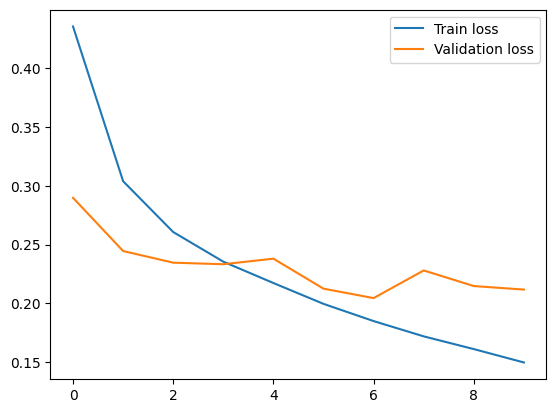

In [41]:
"""
Final program
"""

import sys
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

if torch.cuda.is_available():
  device="cuda"
elif torch.xpu.is_available():
  device="xpu"
elif torch.mps.is_available():
  device="mps"    
else:
  device="cpu"

print("Using device:", device)

mnist_train = datasets.FashionMNIST(root='./data', download=True, train=True, transform=ToTensor())
mnist_test = datasets.FashionMNIST(root='./data', download=True, train=False, transform=ToTensor())

train_dataloader = DataLoader(mnist_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=32, shuffle=True)

model = nn.Sequential(
    nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1, padding_mode="reflect"),
        nn.MaxPool2d(kernel_size=2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Dropout(0.1)
    ),
    nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1, padding_mode="reflect"),
        nn.MaxPool2d(kernel_size=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Dropout(0.1)
    ),
    nn.Flatten(),
    nn.Sequential(
        nn.Linear(64 * 7 * 7, 1000),
        nn.BatchNorm1d(1000),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(1000, 100),
        nn.BatchNorm1d(100),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(100, 10)
    )
).to(device)
print(model)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []
for i in range(0, 10):
    model.train()
    
    loss_sum = 0
    for X, y in train_dataloader:
        y = F.one_hot(y, num_classes=10).type(torch.float32).to(device)
        X = X.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

        loss_sum+=loss.item()
    train_losses.append(loss_sum / len(train_dataloader))

    val_loss_sum = 0
    model.eval()
    with torch.no_grad():
        loss_sum = 0
        for X, y in test_dataloader:
            y = F.one_hot(y, num_classes=10).type(torch.float32).to(device)
            X = X.to(device)

            outputs = model(X)
            loss = loss_fn(outputs, y)

            loss_sum+=loss.item()
        val_losses.append(loss_sum / len(test_dataloader))
    torch.save(model.state_dict(), 'model_' + str(i) + '.pth')

plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.savefig('./data/final.png')

model.eval()
with torch.no_grad():
    accurate = 0
    total = 0
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)
        outputs = nn.functional.softmax(model(X), dim=1)
        correct_pred = (y == outputs.max(dim=1).indices)
        total+=correct_pred.size(0)
        accurate+=correct_pred.type(torch.int).sum().item()
    print("Accuracy on validation data:", accurate / total)

### Step by step flow

In [1]:
"""
First lets explore the dataset
"""
import torch
from torch import nn

import torchvision.datasets as datasets

mnist_train = datasets.FashionMNIST(root='./data', download=True, train=True)
print(mnist_train[2])

100%|█████████████████████████████████████████████████████████████████████████████| 26.4M/26.4M [00:01<00:00, 13.5MB/s]
100%|█████████████████████████████████████████████████████████████████████████████████████| 29.5k/29.5k [00:00<?, ?B/s]
100%|█████████████████████████████████████████████████████████████████████████████| 4.42M/4.42M [00:01<00:00, 4.16MB/s]
100%|█████████████████████████████████████████████████████████████████████████████████████| 5.15k/5.15k [00:00<?, ?B/s]

(<PIL.Image.Image image mode=L size=28x28 at 0x1C2E1927DA0>, 0)


In [2]:
mnist_train[5]

(<PIL.Image.Image image mode=L size=28x28>, 2)

In [3]:
mnist_train[5][0]

In [4]:
"""
Load the baseline model, training, prediction
"""
import sys
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F

import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
mnist_train = datasets.FashionMNIST(root='./data', download=True, train=True, transform=ToTensor())
mnist_test = datasets.FashionMNIST(root='./data', download=True, train=False, transform=ToTensor())

train_dataloader = DataLoader(mnist_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=32, shuffle=True)

Accuracy on validation data: 0.8751


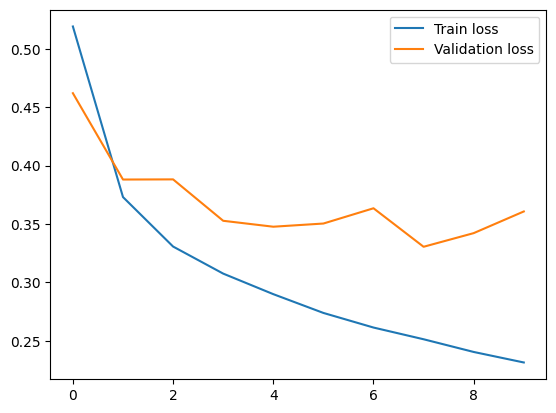

In [5]:
import matplotlib.pyplot as plt

model = nn.Sequential(
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.Linear(500, 50),
    nn.ReLU(),
    nn.Linear(50, 50),
    nn.ReLU(),
    nn.Linear(50, 10)
)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []
for i in range(0, 10):
    model.train()
    loss_sum = 0
    for X, y in train_dataloader:
        X = X.reshape((-1, 784))
        y = F.one_hot(y, num_classes=10).type(torch.float32)

        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

        loss_sum+=loss.item()
    train_losses.append(loss_sum / len(train_dataloader))

    val_loss_sum = 0
    model.eval()
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.reshape((-1, 784))
            y = F.one_hot(y, num_classes=10).type(torch.float32) 
            outputs = model(X)
            loss = loss_fn(outputs, y)
            val_loss_sum+=loss.item()
    val_losses.append(val_loss_sum / len(test_dataloader))
        
model.eval()
with torch.no_grad():
    accurate = 0
    total = 0
    for X, y in test_dataloader:
        X = X.reshape((-1, 784))
        outputs = nn.functional.softmax(model(X), dim=1) 
        correct_pred = (y == outputs.max(dim=1).indices)
        total+=correct_pred.size(0)
        accurate+=correct_pred.type(torch.int).sum().item()
    print("Accuracy on validation data:", accurate / total)


plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.show()

Accuracy on validation data: 0.8714


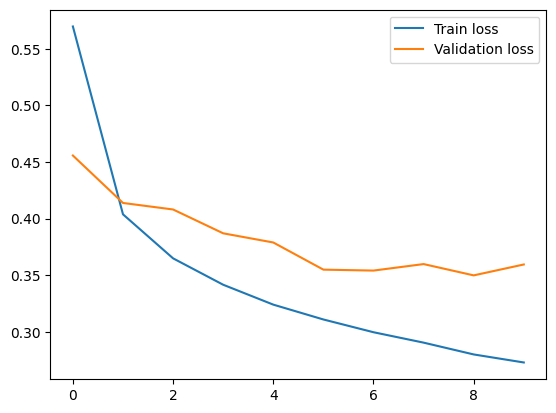

In [6]:
"""
Try the same code as earlier by removing 1 layer
"""

import matplotlib.pyplot as plt

model = nn.Sequential(
    nn.Linear(784, 50),
    nn.ReLU(),
    nn.Linear(50, 50),
    nn.ReLU(),
    nn.Linear(50, 10)
)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []
for i in range(0, 10):
    model.train()
    loss_sum = 0
    for X, y in train_dataloader:
        X = X.reshape((-1, 784))
        y = F.one_hot(y, num_classes=10).type(torch.float32)

        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

        loss_sum+=loss.item()
    train_losses.append(loss_sum / len(train_dataloader))

    val_loss_sum = 0
    model.eval()
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.reshape((-1, 784))
            y = F.one_hot(y, num_classes=10).type(torch.float32) 
            outputs = model(X)
            loss = loss_fn(outputs, y)
            val_loss_sum+=loss.item()
    val_losses.append(val_loss_sum / len(test_dataloader))
        

model.eval()
with torch.no_grad():
    accurate = 0
    total = 0
    for X, y in test_dataloader:
        X = X.reshape((-1, 784))
        outputs = nn.functional.softmax(model(X), dim=1) 
        correct_pred = (y == outputs.max(dim=1).indices)
        total+=correct_pred.size(0)
        accurate+=correct_pred.type(torch.int).sum().item()
    print("Accuracy on validation data:", accurate / total)

plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.show()

In [20]:
"""
We are going to implement a basic CNN model.
"""
import sys
import torch
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

mnist_train = datasets.FashionMNIST(root='./data', download=True, train=True, transform=ToTensor())
mnist_test = datasets.FashionMNIST(root='./data', download=True, train=False, transform=ToTensor())

train_dataloader = DataLoader(mnist_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=32, shuffle=True)

model = nn.Sequential(
    nn.Conv2d(1, 3, kernel_size=(3, 3), padding=1, padding_mode="reflect"), # 1 input channel, 3 output channels(RGB), kernel_size=(3,3) => how large the kernel size is 
    # By default padding will be 0. When working on images, some pixels may be lost, so to preserve the image data. we need to add padding
    # padding_mode="reflect" => it will reflect the data around the matrix. It is better than zeros
    nn.ReLU(), # To break the linearity
    nn.Flatten(), # It will transform from [1,3,28,28] to [1,2352]
    nn.Linear(2352, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
)
# image =  mnist_train[0]
# print(image) 
image = mnist_train[0][0].reshape(1, 1, 28, 28)
output = model(image)
print(output.shape)

torch.Size([1, 10])


In [15]:
"""
Code explaination for above
"""
image =  mnist_train[0]
print(image) 

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000

In [16]:
"""
Code explaination for above
"""
image =  mnist_train[0][0]
print(image)
print(image.shape)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000,

In [17]:
"""
Code explaination above We to reshape the image from [1, 28, 28] to [1, 1, 28, 28]
[1, 28, 28] - 1 color channel, 28*28 pixels size
[1, 1, 28, 28] - only 1 image, 1 color channel, 28*28 pixels size
"""
image =  mnist_train[0][0].reshape(1, 1, 28, 28)
print(image)
print(image.shape)

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [18]:
"""
Code explaination for above.
"""

image = mnist_train[0][0].reshape(1, 1, 28, 28)
output = model(image) 
print(output.shape)

torch.Size([1, 10])


In [21]:
"""
Create the training loope and remaining
"""
import sys
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

mnist_train = datasets.FashionMNIST(root='./data', download=True, train=True, transform=ToTensor())
mnist_test = datasets.FashionMNIST(root='./data', download=True, train=False, transform=ToTensor())

train_dataloader = DataLoader(mnist_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=32, shuffle=True)

model = nn.Sequential(
    nn.Conv2d(1, 3, kernel_size=(3, 3), padding=1, padding_mode="reflect"),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(2352, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for i in range(0, 10):
    model.train()
    
    loss_sum = 0
    for X, y in train_dataloader:
        y = F.one_hot(y, num_classes=10).type(torch.float32)

        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

        loss_sum+=loss.item()
    print(loss_sum)

model.eval()
with torch.no_grad():
    accurate = 0
    total = 0
    for X, y in test_dataloader:
        outputs = nn.functional.softmax(model(X), dim=1)
        correct_pred = (y == outputs.max(dim=1).indices)
        total+=correct_pred.size(0)
        accurate+=correct_pred.type(torch.int).sum().item()
    print("Accuracy on validation data:", accurate / total)

937.9072239026427
640.2312750481069
534.7441628985107
469.98228423669934
420.39488261565566
375.58218798879534
333.56202529463917
300.18872479442507
264.7417606860399
236.27554082451388
Accuracy on validation data: 0.8954


In [23]:
"""
MaxPooling is to reduce the complex model architecture
"""

import sys
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

mnist_train = datasets.FashionMNIST(root='./data', download=True, train=True, transform=ToTensor())
mnist_test = datasets.FashionMNIST(root='./data', download=True, train=False, transform=ToTensor())

train_dataloader = DataLoader(mnist_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=32, shuffle=True)

model = nn.Sequential(
    nn.Conv2d(1, 3, kernel_size=(3, 3), padding=1, padding_mode="reflect"), # (1,28,28) to (3,28,28)
    nn.MaxPool2d(kernel_size=2), # Use maxpooling before Relu. kernel size. # to downsample a feature map by taking the maximum value from a 2x2 window (the kernel).
    # (3,28,28) to (3,14,14)
    nn.ReLU(), 
    nn.Flatten(), # (3,14,14) to (588) 
    nn.Linear(588, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for i in range(0, 10):
    model.train()
    
    loss_sum = 0
    for X, y in train_dataloader:
        y = F.one_hot(y, num_classes=10).type(torch.float32)

        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

        loss_sum+=loss.item()
    print(loss_sum)

model.eval()
with torch.no_grad():
    accurate = 0
    total = 0
    for X, y in test_dataloader:
        outputs = nn.functional.softmax(model(X), dim=1) 
        correct_pred = (y == outputs.max(dim=1).indices)
        total+=correct_pred.size(0)
        accurate+=correct_pred.type(torch.int).sum().item()
    print("Accuracy on validation data:", accurate / total)

1067.1747895628214
732.9145804196596
657.84229259938
603.9853184521198
566.7458258680999
538.6928926445544
511.8561661206186
492.0695710722357
471.6978035867214
454.5267551280558
Accuracy on validation data: 0.8893


In [28]:
"""
Small example. Lets run the model on GPU.(Optional)
"""

if torch.cuda.is_available():
  device="cuda"
elif torch.xpu.is_available():
  device="xpu"
elif torch.mps.is_available():
  device="mps"    
else:
  device="cpu"

print("Using device:", device)



a = torch.tensor([5, 7], device=device, dtype=torch.float32)
b = torch.tensor([3, 4], device=device)

print(a)
print(b)
print(a + b)
print("==========")

model = nn.Sequential(
    nn.Linear(2, 10)
).to(device)

print(a)
print(a.shape)
print(a.reshape(1,2))
print("=============")
outputs = model(a.reshape(1, 2))
print(outputs)
probabilities = nn.functional.softmax(outputs, dim=1)
print(probabilities)
# print(probabilities[0, 0].item())
print(probabilities[0, :].tolist())

Using device: xpu
tensor([5., 7.], device='xpu:0')
tensor([3, 4], device='xpu:0')
tensor([ 8., 11.], device='xpu:0')
tensor([5., 7.], device='xpu:0')
torch.Size([2])
tensor([[5., 7.]], device='xpu:0')
tensor([[-2.0203,  3.4393, -4.0609,  1.5080,  0.0980,  5.9159, -2.6217, -0.9242,
          7.1899, -3.6092]], device='xpu:0', grad_fn=<AddmmBackward0>)
tensor([[7.6469e-05, 1.7971e-02, 9.9371e-06, 2.6051e-03, 6.3601e-04, 2.1386e-01,
         4.1909e-05, 2.2884e-04, 7.6455e-01, 1.5612e-05]], device='xpu:0',
       grad_fn=<SoftmaxBackward0>)
[7.64685682952404e-05, 0.017970699816942215, 9.937109098245855e-06, 0.0026050612796097994, 0.0006360114202834666, 0.21386390924453735, 4.190867184661329e-05, 0.00022883790370542556, 0.76455157995224, 1.5611632989021018e-05]


In [29]:
"""
Let's apply to the model now
"""

import sys
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

if torch.cuda.is_available():
  device="cuda"
elif torch.xpu.is_available():
  device="xpu"
elif torch.mps.is_available():
  device="mps"    
else:
  device="cpu"

print("Using device:", device)

mnist_train = datasets.FashionMNIST(root='./data', download=True, train=True, transform=ToTensor())
mnist_test = datasets.FashionMNIST(root='./data', download=True, train=False, transform=ToTensor())

train_dataloader = DataLoader(mnist_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=32, shuffle=True)

model = nn.Sequential(
    nn.Conv2d(1, 3, kernel_size=(3, 3), padding=1, padding_mode="reflect"),
    nn.MaxPool2d(kernel_size=2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(588, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
).to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for i in range(0, 10):
    model.train()
    
    loss_sum = 0
    for X, y in train_dataloader:
        y = F.one_hot(y, num_classes=10).type(torch.float32).to(device)
        X = X.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

        loss_sum+=loss.item()
    print(loss_sum)

model.eval()
with torch.no_grad():
    accurate = 0
    total = 0
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)
        outputs = nn.functional.softmax(model(X), dim=1) 
        correct_pred = (y == outputs.max(dim=1).indices)
        total+=correct_pred.size(0)
        accurate+=correct_pred.type(torch.int).sum().item()
    print("Accuracy on validation data:", accurate / total)

Using device: xpu
916.7285345122218
649.9062876924872
580.317593999207
527.3127299100161
488.6865928657353
455.1222098097205
424.7631050311029
403.4036399126053
379.8216339601204
362.0827209604904
Accuracy on validation data: 0.902


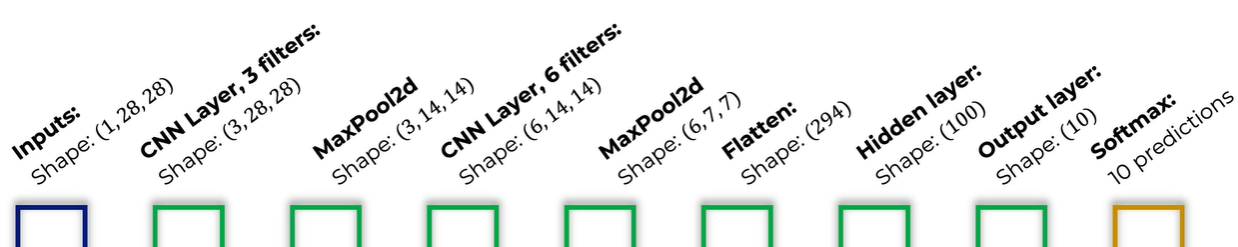

In [30]:
"""
Now advance the CNN complexity
"""
import sys
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

if torch.cuda.is_available():
  device="cuda"
elif torch.xpu.is_available():
  device="xpu"
elif torch.mps.is_available():
  device="mps"    
else:
  device="cpu"

print("Using device:", device)

mnist_train = datasets.FashionMNIST(root='./data', download=True, train=True, transform=ToTensor())
mnist_test = datasets.FashionMNIST(root='./data', download=True, train=False, transform=ToTensor())

train_dataloader = DataLoader(mnist_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=32, shuffle=True)

model = nn.Sequential(
    nn.Sequential(
        nn.Conv2d(1, 3, kernel_size=(3, 3), padding=1, padding_mode="reflect"),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU()
    ),
    nn.Sequential(
        nn.Conv2d(3, 6, kernel_size=(3, 3), padding=1, padding_mode="reflect"),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU(),
    ),
    nn.Flatten(),
    nn.Sequential(
        nn.Linear(294, 100),
        nn.ReLU(),
        nn.Linear(100, 10)
    )
).to(device)
print(model)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for i in range(0, 10):
    model.train()
    
    loss_sum = 0
    for X, y in train_dataloader:
        y = F.one_hot(y, num_classes=10).type(torch.float32).to(device)
        X = X.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

        loss_sum+=loss.item()
    print(loss_sum)

model.eval()
with torch.no_grad():
    accurate = 0
    total = 0
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)
        outputs = nn.functional.softmax(model(X), dim=1) 
        correct_pred = (y == outputs.max(dim=1).indices)
        total+=correct_pred.size(0)
        accurate+=correct_pred.type(torch.int).sum().item()
    print("Accuracy on validation data:", accurate / total)

Using device: xpu
Sequential(
  (0): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Sequential(
    (0): Linear(in_features=294, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)
1149.486222565174
755.7644744738936
666.518862888217
618.9464189484715
583.5561234541237
550.0122457705438
530.2492076270282
509.409500118345
491.6370588503778
473.81675842404366
Accuracy on validation data: 0.888


In [34]:
import sys
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

if torch.cuda.is_available():
  device="cuda"
elif torch.xpu.is_available():
  device="xpu"
elif torch.mps.is_available():
  device="mps"    
else:
  device="cpu"

print("Using device:", device)

mnist_train = datasets.FashionMNIST(root='./data', download=True, train=True, transform=ToTensor())
mnist_test = datasets.FashionMNIST(root='./data', download=True, train=False, transform=ToTensor())

train_dataloader = DataLoader(mnist_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=32, shuffle=True)

model = nn.Sequential(
    nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1, padding_mode="reflect"),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU()
    ),
    nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1, padding_mode="reflect"), # We're adding additional channels, because when conveting from 28*28 to 14*14,so much info. is loset, 
        # to recover most of the information safely
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU(),
    ),
    nn.Flatten(),
    nn.Sequential(
        nn.Linear(64 * 7 * 7, 1000),
        nn.ReLU(),
        nn.Linear(1000, 100),
        nn.ReLU(),
        nn.Linear(100, 10)
    )
).to(device)
print(model)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for i in range(0, 10):
    model.train()
    
    loss_sum = 0
    for X, y in train_dataloader:
        y = F.one_hot(y, num_classes=10).type(torch.float32).to(device)
        X = X.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

        loss_sum+=loss.item()
    print(loss_sum)

model.eval()
with torch.no_grad():
    accurate = 0
    total = 0
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)
        outputs = nn.functional.softmax(model(X), dim=1) 
        correct_pred = (y == outputs.max(dim=1).indices)
        total+=correct_pred.size(0)
        accurate+=correct_pred.type(torch.int).sum().item()
    print("Accuracy on validation data:", accurate / total)

Using device: xpu
Sequential(
  (0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Sequential(
    (0): Linear(in_features=3136, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)
795.5132691562176
501.4614293798804
408.076985437423
337.44303352199495
282.5292501170188
234.17583763436414
183.34692759302197
150.46141036355402
125.3079959700699
105.86972747294931
Accuracy on validation data: 0.9142


In [35]:
"""
The above one is more complex, but still we got 92% accuracy
"""
"""
Now we want to use dropout for more generalization.
Dropout will also help in preventing the overfitting problem.
"""

import sys
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

if torch.cuda.is_available():
  device="cuda"
elif torch.xpu.is_available():
  device="xpu"
elif torch.mps.is_available():
  device="mps"    
else:
  device="cpu"

print("Using device:", device)

mnist_train = datasets.FashionMNIST(root='./data', download=True, train=True, transform=ToTensor())
mnist_test = datasets.FashionMNIST(root='./data', download=True, train=False, transform=ToTensor())

train_dataloader = DataLoader(mnist_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=32, shuffle=True)

model = nn.Sequential(
    nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1, padding_mode="reflect"),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU(),
        nn.Dropout(0.1)
    ),
    nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1, padding_mode="reflect"),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU(),
        nn.Dropout(0.1)
    ),
    nn.Flatten(),
    nn.Sequential(
        nn.Linear(64 * 7 * 7, 1000),
        nn.ReLU(),
        nn.Dropout(0.3), # We can keep till 30%, because most of the learning features will be here. So don't give biggere value here.
        nn.Linear(1000, 100),
        nn.ReLU(),
        nn.Dropout(0.5), # We can keep 50%, because there is not much data here.
        nn.Linear(100, 10)
    )
).to(device)
print(model)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for i in range(0, 10):
    model.train()
    
    loss_sum = 0
    for X, y in train_dataloader:
        y = F.one_hot(y, num_classes=10).type(torch.float32).to(device)
        X = X.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

        loss_sum+=loss.item()
    print(loss_sum)

model.eval() # While inference, dropout will be disabled
with torch.no_grad():
    accurate = 0
    total = 0
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)
        outputs = nn.functional.softmax(model(X), dim=1) 
        correct_pred = (y == outputs.max(dim=1).indices)
        total+=correct_pred.size(0)
        accurate+=correct_pred.type(torch.int).sum().item()
    print("Accuracy on validation data:", accurate / total)

Using device: xpu
Sequential(
  (0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Sequential(
    (0): Linear(in_features=3136, out_features=1000, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1000, out_features=100, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)
1017.4200768172741
639.5595557242632
539.5753452535719
482.631598521024
440.0545946881175


In [37]:
"""
Optimize further: Batch Normalization.
Can we do this inside the network - YES, We can.
"""

import sys
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

if torch.cuda.is_available():
  device="cuda"
elif torch.xpu.is_available():
  device="xpu"
elif torch.mps.is_available():
  device="mps"    
else:
  device="cpu"

print("Using device:", device)

mnist_train = datasets.FashionMNIST(root='./data', download=True, train=True, transform=ToTensor())
mnist_test = datasets.FashionMNIST(root='./data', download=True, train=False, transform=ToTensor())

train_dataloader = DataLoader(mnist_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=32, shuffle=True)

model = nn.Sequential(
    nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1, padding_mode="reflect"),
        nn.MaxPool2d(kernel_size=2),
        nn.BatchNorm2d(32), # Need to learn 32 ideal means and standard deviations
        nn.ReLU(),
        nn.Dropout(0.1)
    ),
    nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1, padding_mode="reflect"),
        nn.MaxPool2d(kernel_size=2),
        nn.BatchNorm2d(64), # Need to learn 64 ideal means and standard deviations
        nn.ReLU(),
        nn.Dropout(0.1)
    ),
    nn.Flatten(),
    nn.Sequential(
        nn.Linear(64 * 7 * 7, 1000),
        nn.BatchNorm1d(1000),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(1000, 100),
        nn.BatchNorm1d(100),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(100, 10)
    )
).to(device)
print(model)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for i in range(0, 10):
    model.train()
    
    loss_sum = 0
    for X, y in train_dataloader:
        y = F.one_hot(y, num_classes=10).type(torch.float32).to(device)
        X = X.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

        loss_sum+=loss.item()
    print(loss_sum)

model.eval()
with torch.no_grad():
    accurate = 0
    total = 0
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)
        outputs = nn.functional.softmax(model(X), dim=1)
        correct_pred = (y == outputs.max(dim=1).indices)
        total+=correct_pred.size(0)
        accurate+=correct_pred.type(torch.int).sum().item()
    print("Accuracy on validation data:", accurate / total)

Using device: xpu
Sequential(
  (0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.1, inplace=False)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.1, inplace=False)
  )
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Sequential(
    (0): Linear(in_features=3136, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4

Using device: xpu
Sequential(
  (0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.1, inplace=False)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.1, inplace=False)
  )
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Sequential(
    (0): Linear(in_features=3136, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4

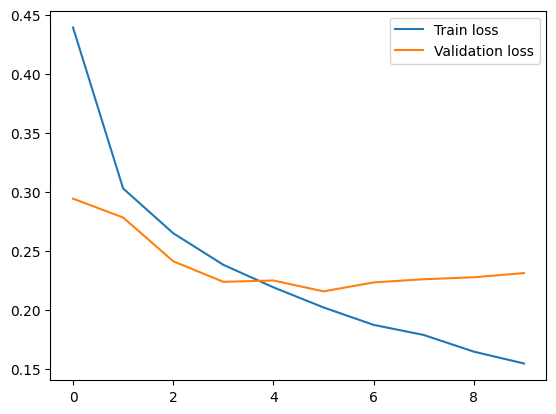

In [39]:
"""
Final program
"""

import sys
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

if torch.cuda.is_available():
  device="cuda"
elif torch.xpu.is_available():
  device="xpu"
elif torch.mps.is_available():
  device="mps"    
else:
  device="cpu"

print("Using device:", device)

mnist_train = datasets.FashionMNIST(root='./data', download=True, train=True, transform=ToTensor())
mnist_test = datasets.FashionMNIST(root='./data', download=True, train=False, transform=ToTensor())

train_dataloader = DataLoader(mnist_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=32, shuffle=True)

model = nn.Sequential(
    nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1, padding_mode="reflect"),
        nn.MaxPool2d(kernel_size=2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Dropout(0.1)
    ),
    nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1, padding_mode="reflect"),
        nn.MaxPool2d(kernel_size=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Dropout(0.1)
    ),
    nn.Flatten(),
    nn.Sequential(
        nn.Linear(64 * 7 * 7, 1000),
        nn.BatchNorm1d(1000),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(1000, 100),
        nn.BatchNorm1d(100),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(100, 10)
    )
).to(device)
print(model)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []
for i in range(0, 10):
    model.train()
    
    loss_sum = 0
    for X, y in train_dataloader:
        y = F.one_hot(y, num_classes=10).type(torch.float32).to(device)
        X = X.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

        loss_sum+=loss.item()
    train_losses.append(loss_sum / len(train_dataloader))

    val_loss_sum = 0
    model.eval()
    with torch.no_grad():
        loss_sum = 0
        for X, y in test_dataloader:
            y = F.one_hot(y, num_classes=10).type(torch.float32).to(device)
            X = X.to(device)

            outputs = model(X)
            loss = loss_fn(outputs, y)

            loss_sum+=loss.item()
        val_losses.append(loss_sum / len(test_dataloader))
    torch.save(model.state_dict(), 'model_' + str(i) + '.pth')

plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.savefig('./data/final.png')

model.eval()
with torch.no_grad():
    accurate = 0
    total = 0
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)
        outputs = nn.functional.softmax(model(X), dim=1)
        correct_pred = (y == outputs.max(dim=1).indices)
        total+=correct_pred.size(0)
        accurate+=correct_pred.type(torch.int).sum().item()
    print("Accuracy on validation data:", accurate / total)

In [43]:
"""
Just know if you want save and load the model
"""
import sys
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

if torch.cuda.is_available():
  device="cuda"
elif torch.xpu.is_available():
  device="xpu"
elif torch.mps.is_available():
  device="mps"    
else:
  device="cpu"

print("Using device:", device)

mnist_test = datasets.FashionMNIST(root='./data', download=True, train=False, transform=ToTensor())

test_dataloader = DataLoader(mnist_test, batch_size=32, shuffle=True)

model = nn.Sequential(
    nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1, padding_mode="reflect"),
        nn.MaxPool2d(kernel_size=2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Dropout(0.1)
    ),
    nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1, padding_mode="reflect"),
        nn.MaxPool2d(kernel_size=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Dropout(0.1)
    ),
    nn.Flatten(),
    nn.Sequential(
        nn.Linear(64 * 7 * 7, 1000),
        nn.BatchNorm1d(1000),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(1000, 100),
        nn.BatchNorm1d(100),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(100, 10)
    )
)
model.load_state_dict(torch.load('model_5.pth', weights_only=True, map_location=device))
model = model.to(device)

model.eval()
with torch.no_grad():
    accurate = 0
    total = 0
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)
        outputs = nn.functional.softmax(model(X), dim=1) 
        correct_pred = (y == outputs.max(dim=1).indices)
        total+=correct_pred.size(0)
        accurate+=correct_pred.type(torch.int).sum().item()
    print("Accuracy on validation data:", accurate / total)


Using device: xpu
Accuracy on validation data: 0.9224
